In [1]:
import cv2
import numpy as np
import os
import torch

In [ ]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

In [3]:
def extract_frames(video_path, seq_len, img_h, img_w):
  frames = []
  video_reader = cv2.VideoCapture(video_path)

  # Number of Frames
  t_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # Interval to skip the frames
  window = max(int(t_frames/seq_len), 1)

  #Loop
  for frame in range(seq_len):
      video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame * window)
      ret, frame = video_reader.read()
      if not ret:
          break
      resized_frame = cv2.resize(frame, (img_h, img_w))
      frames.append(resized_frame / 255)
  video_reader.release()
  return frames

In [4]:
h, w = 64, 64
seq_len = 10
path = "/content/UCF50"
classes = ["PushUps", "Diving", "JavelinThrow", "Skijet", "VolleyballSpiking"]
idx_to_class = {i:class_name for i, class_name in enumerate(classes)}
feature_set = []
labels = []

for idx, class_name in enumerate(classes):
    files_list = os.listdir(os.path.join(path, class_name))
    for file_name in files_list:
        video_file_path = os.path.join(path, class_name, file_name)
        frames = extract_frames(video_file_path, seq_len, h, w)
        if len(frames) == seq_len:
            feature_set.append(frames)
            labels.append(idx)
feature_set = np.asarray(feature_set)
labels = np.array(labels)

In [5]:
one_hot_encoded_labels = np.zeros((len(labels), len(classes)))

for i in range(len(labels)):
    one_hot_encoded_labels[i, labels[i]] = 1

from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(feature_set, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True)

In [6]:
features_train = torch.tensor(features_train.transpose(0, 1, 4, 2, 3)).float()
features_test = torch.tensor(features_test.transpose(0, 1, 4, 2, 3)).float()
labels_train = torch.tensor(labels_train).float()
labels_test = torch.tensor(labels_test).float()

features_train.shape, features_test.shape, labels_train.shape, labels_test.shape

(torch.Size([444, 10, 3, 64, 64]),
 torch.Size([148, 10, 3, 64, 64]),
 torch.Size([444, 5]),
 torch.Size([148, 5]))

In [7]:
from torch.utils.data import Dataset, DataLoader
class ActionDataset(Dataset):
  def __init__(self, data, labels, transform = None):
    self.data = data
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    sample = self.data[index]
    label = self.labels[index]
    if self.transform:
      sample = self.transform(sample)

    return sample, label

train_dataset = ActionDataset(features_train, labels_train)
test_dataset = ActionDataset(features_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 4)

In [8]:
import torch
import torch.nn as nn

#Model Architecture
class LRCNModel(nn.Module):
    def __init__(self, sequence_length, image_height, image_width, num_classes):
        super(LRCNModel, self).__init__()

        self.sequence_length = sequence_length
        self.image_height = image_height
        self.image_width = image_width

        self.seq1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4)),
            nn.Dropout(0.25)
        )

        self.seq2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4)),
            nn.Dropout(0.25)
        )

        self.seq3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(0.25)
        )

        self.seq4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(0.25)
        )

        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        batch_size, time_steps, channels, height, width = x.size()
        x = x.view(batch_size * time_steps, channels, height, width)
        out = self.seq1(x)
        out = self.seq2(out)
        out = self.seq3(out)
        out = self.seq4(out)
        out = self.flatten(out)
        out = out.view(batch_size, time_steps, -1)
        out, _ = self.lstm(out)
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.softmax(out)

        return out

In [9]:
from torch.optim import Adam

device = 'cuda' if torch.cuda.is_available else 'cpu'
model = LRCNModel(seq_len, h, w, len(classes)).to(device)
optimizer = Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

In [11]:
#Training Loop
early_stopping = EarlyStopping(patience=10, min_delta=0.001)
EPOCHS = 100
for epoch in range(EPOCHS):
  total_train_loss = 0
  total_test_loss = 0
  correct_pred = 0
  n_train_samples = 0
  n_test_samples = 0
  model.train()
  for i, (batch, label) in enumerate(train_loader):
    batch = batch.to(device)
    label = label.to(device)

    output = model(batch)
    optimizer.zero_grad()
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    total_train_loss += loss
    n_train_samples += label.size(0)

  model.eval()
  with torch.no_grad():
    for i, (batch, label) in enumerate(test_loader):
      batch = batch.to(device)
      label = label.to(device)
      output = model(batch)
      loss = criterion(output, label)
      total_test_loss += loss

      _, predicted = torch.max(output, -1)
      _, actual_label = torch.max(label, -1)
      n_test_samples += label.size(0)
      correct_pred += (predicted == actual_label).sum()

    early_stopping(total_test_loss/n_test_samples)

  if((epoch+1)%10 == 0):
    print(f'Epoch : {epoch + 1} | Train Loss : {(total_train_loss/n_train_samples):.2f} | Test Accuracy : {(100*correct_pred/n_test_samples):.2f}')

Epoch : 10 | Train Loss : 0.32 | Test Accuracy : 64.19
Epoch : 20 | Train Loss : 0.28 | Test Accuracy : 79.73
Epoch : 30 | Train Loss : 0.26 | Test Accuracy : 86.49
Epoch : 40 | Train Loss : 0.26 | Test Accuracy : 88.51
Epoch : 50 | Train Loss : 0.25 | Test Accuracy : 89.86
Epoch : 60 | Train Loss : 0.25 | Test Accuracy : 85.81
Epoch : 70 | Train Loss : 0.24 | Test Accuracy : 88.51
Epoch : 80 | Train Loss : 0.24 | Test Accuracy : 93.24
Epoch : 90 | Train Loss : 0.24 | Test Accuracy : 92.57
Epoch : 100 | Train Loss : 0.23 | Test Accuracy : 93.24


In [12]:
model_path = "action_recog_model.pth"

In [13]:
torch.save(model.state_dict(), "action_recog_model.pth")

In [14]:
# Load the saved model
loaded_model = LRCNModel(seq_len, h, w, len(classes)).to(device)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [22]:
#Process a test video
import random
import matplotlib.pyplot as plt

seq_len = 10
h = 64
w = 64
classes = ["PushUps", "Diving", "JavelinThrow", "Skijet", "VolleyballSpiking"]
idx_to_class = {i:class_name for i, class_name in enumerate(classes)}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def recognise_action(video_path):
  features = []
  frames = extract_frames(video_path, seq_len, h, w)
  random_frame = cv2.resize(random.choice(frames), (1080, 720))
  if len(frames) == seq_len:
    features.append(frames)
    features = torch.tensor(np.asarray(features).transpose(0, 1, 4, 2, 3)).float()
  features = features.to(device)
  loaded_model.eval()
  output = loaded_model(features)
  _, predicted = torch.max(output, -1)
  pred_label = predicted.item()
  plt.imshow(random_frame)
  plt.axis('off')
  plt.text(random_frame.shape[1]/2, random_frame.shape[0] + 40, idx_to_class[pred_label], fontsize=12, ha='center')
  plt.show()

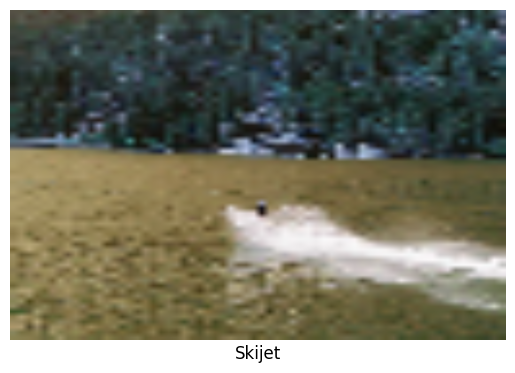

In [23]:
recognise_action("pexels_videos_2711207 (2160p).mp4")

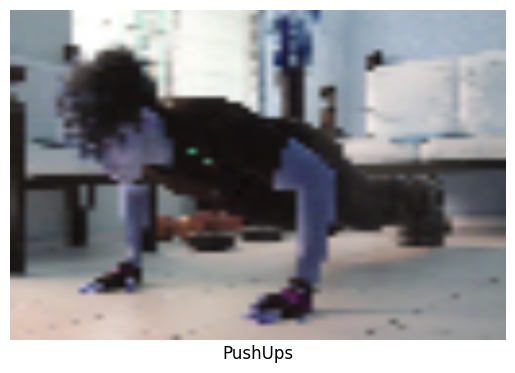

In [24]:
recognise_action("production_id_5195148 (1080p).mp4")

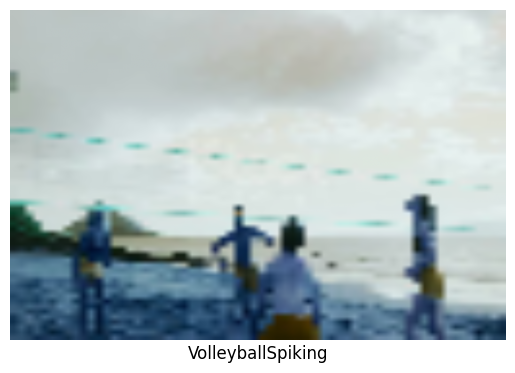

In [25]:
recognise_action("istockphoto-1124832649-640_adpp_is.mp4")